In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.chdir('../../')
os.getcwd()

'/home/bunny/projects/IConNet'

In [5]:
dataset_name = 'iemocap'
experiment_prefix = "scb15"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/'
data_dir = "../data/data_preprocessed/"

sr = 16000
batch_size = 2
in_channels = 1
kernel_size = 511
stride = 125
embedding_dim = 511
num_embeddings = 384
cls_dim = 512
learning_rate = 1e-4
max_num_tokens = 2048
num_classes = 4
commitment_cost = 0.1

In [6]:
from IConNet.acov.audio_vqvae import VqVaeClsLoss
from IConNet.trainer.train_torch import get_dataloader
from IConNet.trainer.train_torch import Trainer_SCB10 as Trainer
from IConNet.acov.model import SCB15 as SCB
from omegaconf import OmegaConf as ocf

In [7]:
iconnet_config_path = f'config/model/m19win.yaml'
iconnet_config = ocf.load(iconnet_config_path)
print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [256], 'kernel_size': [511], 'stride': [2], 'window_k': [5], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


In [9]:
dataset_config_path = f'config/dataset/{dataset_name}4.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)
train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=batch_size)
print(batch_size)

{'name': 'iemocap', 'dataset_class': 'WaveformDataset', 'root': 'iemocap/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label4', 'feature_name': 'audio16k', 'num_classes': 4, 'label_values': ['neu', 'hap', 'sad', 'ang'], 'classnames': ['neu', 'hap', 'sad', 'ang'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}
2


In [10]:
loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=0, loss_recon=0, loss_cls=1)

trainer = Trainer(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=8)
trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size,
               loss_ratio=loss_ratio)

In [11]:
codebook_pretrained_path = f'../scb11_models/ravdess/epoch=220.codebook.pt'
model = SCB(
    in_channels=in_channels,    
    num_embeddings=num_embeddings, 
    stride=stride,
    embedding_dim=embedding_dim, 
    num_classes=num_classes, 
    cls_dim=512,
    sample_rate=sr,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='minami',
    iconnet_config=iconnet_config,
)

In [12]:
trainer.setup(model=model, lr=learning_rate)

In [13]:
trainer.fit(n_epoch=100, self_supervised=False, train_task='embedding', test_n_epoch=10)

  0%|▏                                                 | 0.476833976833989/100 [58:52<2763:42:41, 99970.31s/it]

Epoch: 1	Loss: 1.159 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.159]	Val_acc: 72/197 (36.55%)

Saved new best val model: ../scb15_models/iemocap/model.epoch=1.step=864.loss=1.159.val_acc=0.365.pt


  1%|▋                                                 | 1.4295366795367364/100 [2:08:36<41:19:40, 1509.38s/it]

Correct: 356/988 (0.3603)
Saved new best test model: ../scb15_models/iemocap/model.epoch=1.step=1727.test_acc=0.3603.pt
{'acc_unweighted': tensor(0.2658, device='cuda:0'),
 'acc_weighted': tensor(0.3603, device='cuda:0'),
 'f1s_unweighted': tensor(0.1595, device='cuda:0'),
 'f1s_weighted': tensor(0.2068, device='cuda:0'),
 'rocauc': tensor(0.6997, device='cuda:0'),
 'uar': tensor(0.2658, device='cuda:0'),
 'wap': tensor(0.2649, device='cuda:0')}
{'acc_detail': tensor([0.0633, 1.0000, 0.0000, 0.0000], device='cuda:0'),
 'f1s_detail': tensor([0.1152, 0.5229, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.6364, 0.3540, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.0633, 1.0000, 0.0000, 0.0000], device='cuda:0'),
 'rocauc_detail': tensor([0.7692, 0.6234, 0.7236, 0.6823], device='cuda:0')}
tensor([[ 14, 207,   0,   0],
        [  0, 342,   0,   0],
        [  0, 217,   0,   0],
        [  8, 200,   0,   0]], device='cuda:0')


  2%|▉                                             | 1.9063706563707945/100 [3:06:55<2830:25:11, 103875.36s/it]

Epoch: 2	Loss: 1.399 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.399]	Val_acc: 34/197 (17.26%)



  3%|█▎                                            | 2.8590733590736597/100 [5:03:18<2793:02:46, 103509.07s/it]

Epoch: 3	Loss: 1.462 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.462]	Val_acc: 66/197 (33.50%)



  4%|█▊                                             | 3.811776061776525/100 [6:58:33<2711:07:36, 101468.31s/it]

Epoch: 4	Loss: 1.187 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.187]	Val_acc: 60/197 (30.46%)



  5%|██▎                                             | 4.76447876447939/100 [8:53:58<2680:08:18, 101311.98s/it]

Epoch: 5	Loss: 1.740 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.740]	Val_acc: 82/197 (41.62%)

Saved new best val model: ../scb15_models/iemocap/model.epoch=5.step=7772.loss=1.740.val_acc=0.416.pt


  6%|██▋                                           | 5.717181467182255/100 [10:50:11<2720:21:33, 103871.45s/it]

Epoch: 6	Loss: 1.359 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.359]	Val_acc: 100/197 (50.76%)

Saved new best val model: ../scb15_models/iemocap/model.epoch=6.step=9499.loss=1.359.val_acc=0.508.pt


  7%|███▏                                           | 6.66988416988512/100 [12:45:44<2673:43:55, 103133.22s/it]

Epoch: 7	Loss: 0.779 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.779]	Val_acc: 103/197 (52.28%)

Saved new best val model: ../scb15_models/iemocap/model.epoch=7.step=11226.loss=0.779.val_acc=0.523.pt


  8%|███▌                                          | 7.622586872587985/100 [14:41:23<2581:08:25, 100588.50s/it]

Epoch: 8	Loss: 3.937 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=3.937]	Val_acc: 93/197 (47.21%)



  9%|████                                           | 8.57528957529085/100 [16:37:45<2613:35:50, 102914.74s/it]

Epoch: 9	Loss: 0.907 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.907]	Val_acc: 103/197 (52.28%)



 10%|████▍                                         | 9.527992277993715/100 [18:35:19<2683:04:29, 106763.07s/it]

Epoch: 10	Loss: 1.814 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.814]	Val_acc: 97/197 (49.24%)



 10%|████▊                                         | 10.48069498069658/100 [20:30:12<2570:07:19, 103356.92s/it]

Epoch: 11	Loss: 0.922 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.922]	Val_acc: 109/197 (55.33%)

Saved new best val model: ../scb15_models/iemocap/model.epoch=11.step=18134.loss=0.922.val_acc=0.553.pt


 11%|█████▌                                           | 11.433397683399445/100 [21:39:31<37:24:59, 1520.89s/it]

Correct: 477/988 (0.4828)
Saved new best test model: ../scb15_models/iemocap/model.epoch=11.step=18997.test_acc=0.4828.pt
{'acc_unweighted': tensor(0.4694, device='cuda:0'),
 'acc_weighted': tensor(0.4828, device='cuda:0'),
 'f1s_unweighted': tensor(0.4209, device='cuda:0'),
 'f1s_weighted': tensor(0.4399, device='cuda:0'),
 'rocauc': tensor(0.7631, device='cuda:0'),
 'uar': tensor(0.4694, device='cuda:0'),
 'wap': tensor(0.4561, device='cuda:0')}
{'acc_detail': tensor([0.8145, 0.5322, 0.5023, 0.0288], device='cuda:0'),
 'f1s_detail': tensor([0.5365, 0.5409, 0.5561, 0.0500], device='cuda:0'),
 'precision_detail': tensor([0.4000, 0.5498, 0.6229, 0.1875], device='cuda:0'),
 'recall_detail': tensor([0.8145, 0.5322, 0.5023, 0.0288], device='cuda:0'),
 'rocauc_detail': tensor([0.8179, 0.7182, 0.8513, 0.6650], device='cuda:0')}
tensor([[180,  28,   6,   7],
        [ 89, 182,  55,  16],
        [ 25,  80, 109,   3],
        [156,  41,   5,   6]], device='cuda:0')


 12%|█████▎                                       | 11.910231660233503/100 [22:37:55<2498:17:47, 102098.88s/it]

Epoch: 12	Loss: 1.426 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.426]	Val_acc: 96/197 (48.73%)



 13%|█████▊                                       | 12.862934362936368/100 [24:34:51<2465:14:06, 101849.27s/it]

Epoch: 13	Loss: 1.134 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.134]	Val_acc: 109/197 (55.33%)



 14%|██████▏                                      | 13.815637065639233/100 [26:31:03<2498:13:42, 104353.30s/it]

Epoch: 14	Loss: 0.345 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.345]	Val_acc: 96/197 (48.73%)



 15%|██████▋                                      | 14.768339768342098/100 [28:27:41<2452:47:45, 103600.77s/it]

Epoch: 15	Loss: 1.240 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.240]	Val_acc: 80/197 (40.61%)



 16%|███████                                      | 15.721042471044964/100 [30:22:53<2394:06:12, 102264.82s/it]

Epoch: 16	Loss: 0.595 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.595]	Val_acc: 102/197 (51.78%)



 17%|███████▋                                      | 16.67374517374783/100 [32:19:57<2382:53:13, 102949.47s/it]

Epoch: 17	Loss: 1.914 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.914]	Val_acc: 107/197 (54.31%)



 18%|███████▉                                     | 17.626447876450694/100 [34:16:04<2450:28:19, 107093.84s/it]

Epoch: 18	Loss: 0.669 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.669]	Val_acc: 107/197 (54.31%)



 19%|████████▌                                     | 18.57915057915356/100 [36:11:45<2346:01:39, 103728.95s/it]

Epoch: 19	Loss: 1.340 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.340]	Val_acc: 104/197 (52.79%)



 20%|████████▊                                    | 19.531853281856424/100 [38:07:34<2267:24:45, 101439.96s/it]

Epoch: 20	Loss: 0.564 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.564]	Val_acc: 91/197 (46.19%)



 20%|█████████▍                                    | 20.48455598455929/100 [40:04:33<2313:35:10, 104745.82s/it]

Epoch: 21	Loss: 0.651 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.651]	Val_acc: 114/197 (57.87%)

Saved new best val model: ../scb15_models/iemocap/model.epoch=21.step=35404.loss=0.651.val_acc=0.579.pt


 21%|██████████▌                                      | 21.437258687262155/100 [41:12:31<33:27:56, 1533.51s/it]

Correct: 497/988 (0.5030)
Saved new best test model: ../scb15_models/iemocap/model.epoch=21.step=36267.test_acc=0.5030.pt
{'acc_unweighted': tensor(0.4723, device='cuda:0'),
 'acc_weighted': tensor(0.5030, device='cuda:0'),
 'f1s_unweighted': tensor(0.4434, device='cuda:0'),
 'f1s_weighted': tensor(0.4630, device='cuda:0'),
 'rocauc': tensor(0.7808, device='cuda:0'),
 'uar': tensor(0.4723, device='cuda:0'),
 'wap': tensor(0.4808, device='cuda:0')}
{'acc_detail': tensor([0.6063, 0.6813, 0.5438, 0.0577], device='cuda:0'),
 'f1s_detail': tensor([0.5317, 0.5704, 0.5728, 0.0988], device='cuda:0'),
 'precision_detail': tensor([0.4735, 0.4905, 0.6051, 0.3429], device='cuda:0'),
 'recall_detail': tensor([0.6063, 0.6813, 0.5438, 0.0577], device='cuda:0'),
 'rocauc_detail': tensor([0.7925, 0.7347, 0.8753, 0.7205], device='cuda:0')}
tensor([[134,  71,   9,   7],
        [ 42, 233,  53,  14],
        [  9,  88, 118,   2],
        [ 98,  83,  15,  12]], device='cuda:0')


 22%|█████████▊                                   | 21.914092664096213/100 [42:12:08<2254:48:09, 103953.33s/it]

Epoch: 22	Loss: 1.312 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.312]	Val_acc: 114/197 (57.87%)



 23%|██████████▎                                  | 22.866795366799078/100 [44:06:33<2285:06:46, 106651.95s/it]

Epoch: 23	Loss: 2.715 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.715]	Val_acc: 113/197 (57.36%)



 24%|██████████▋                                  | 23.819498069501943/100 [46:02:11<2189:03:36, 103446.63s/it]

Epoch: 24	Loss: 1.070 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.070]	Val_acc: 103/197 (52.28%)



 25%|███████████▍                                  | 24.77220077220481/100 [47:59:38<2194:00:52, 104993.80s/it]

Epoch: 25	Loss: 0.341 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.341]	Val_acc: 108/197 (54.82%)



 26%|███████████▌                                 | 25.724903474907673/100 [49:54:46<2135:48:30, 103519.36s/it]

Epoch: 26	Loss: 0.918 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.918]	Val_acc: 101/197 (51.27%)



 27%|████████████▎                                 | 26.67760617761054/100 [51:51:29<2151:02:40, 105612.49s/it]

Epoch: 27	Loss: 0.627 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.627]	Val_acc: 106/197 (53.81%)



 28%|████████████▍                                | 27.630308880313404/100 [53:45:42<2058:25:18, 102395.33s/it]

Epoch: 28	Loss: 1.088 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.088]	Val_acc: 89/197 (45.18%)



 29%|█████████████▏                                | 28.58301158301627/100 [55:43:26<2038:15:26, 102744.84s/it]

Epoch: 29	Loss: 0.872 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.872]	Val_acc: 113/197 (57.36%)



 30%|█████████████▎                               | 29.535714285719134/100 [57:39:38<2028:16:07, 103623.66s/it]

Epoch: 30	Loss: 0.665 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.665]	Val_acc: 112/197 (56.85%)



 30%|██████████████▋                                 | 30.488416988422/100 [59:34:35<2020:49:01, 104657.97s/it]

Epoch: 31	Loss: 1.481 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.481]	Val_acc: 107/197 (54.31%)



 31%|███████████████▍                                 | 31.441119691124864/100 [60:45:53<29:37:41, 1555.77s/it]

Correct: 543/988 (0.5496)
Saved new best test model: ../scb15_models/iemocap/model.epoch=31.step=53537.test_acc=0.5496.pt
{'acc_unweighted': tensor(0.5268, device='cuda:0'),
 'acc_weighted': tensor(0.5496, device='cuda:0'),
 'f1s_unweighted': tensor(0.5278, device='cuda:0'),
 'f1s_weighted': tensor(0.5384, device='cuda:0'),
 'rocauc': tensor(0.7914, device='cuda:0'),
 'uar': tensor(0.5268, device='cuda:0'),
 'wap': tensor(0.5452, device='cuda:0')}
{'acc_detail': tensor([0.5701, 0.6871, 0.5806, 0.2692], device='cuda:0'),
 'f1s_detail': tensor([0.5767, 0.5964, 0.5986, 0.3394], device='cuda:0'),
 'precision_detail': tensor([0.5833, 0.5269, 0.6176, 0.4590], device='cuda:0'),
 'recall_detail': tensor([0.5701, 0.6871, 0.5806, 0.2692], device='cuda:0'),
 'rocauc_detail': tensor([0.8264, 0.7459, 0.8803, 0.7130], device='cuda:0')}
tensor([[126,  56,   9,  30],
        [ 16, 235,  61,  30],
        [  6,  79, 126,   6],
        [ 68,  76,   8,  56]], device='cuda:0')


 32%|██████████████▎                              | 31.917953667958923/100 [61:45:22<2002:16:57, 105875.45s/it]

Epoch: 32	Loss: 1.387 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.387]	Val_acc: 112/197 (56.85%)



 33%|██████████████▊                              | 32.870656370661784/100 [63:42:17<1937:45:00, 103917.31s/it]

Epoch: 33	Loss: 0.483 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.483]	Val_acc: 103/197 (52.28%)



 34%|███████████████▌                              | 33.82335907336465/100 [65:37:06<1959:02:03, 106571.20s/it]

Epoch: 34	Loss: 1.762 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.762]	Val_acc: 97/197 (49.24%)



 35%|███████████████▋                             | 34.776061776067515/100 [67:34:56<1914:33:24, 105672.92s/it]

Epoch: 35	Loss: 1.712 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.712]	Val_acc: 108/197 (54.82%)



 36%|████████████████▍                             | 35.72876447877038/100 [69:31:12<1883:38:56, 105508.11s/it]

Epoch: 36	Loss: 1.774 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.774]	Val_acc: 100/197 (50.76%)



 37%|████████████████▌                            | 36.681467181473245/100 [72:12:45<1945:43:03, 110624.55s/it]

Epoch: 37	Loss: 1.046 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.046]	Val_acc: 108/197 (54.82%)



 38%|█████████████████▎                            | 37.63416988417611/100 [74:08:47<1857:49:51, 107241.28s/it]

Epoch: 38	Loss: 1.059 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.059]	Val_acc: 101/197 (51.27%)



 39%|█████████████████▎                           | 38.586872586878975/100 [76:05:14<1784:24:36, 104601.03s/it]

Epoch: 39	Loss: 0.422 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.422]	Val_acc: 99/197 (50.25%)



 40%|██████████████████▏                           | 39.53957528958184/100 [78:02:29<1770:13:49, 105404.97s/it]

Epoch: 40	Loss: 0.827 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.827]	Val_acc: 107/197 (54.31%)



 40%|██████████████████▏                          | 40.492277992284706/100 [79:58:50<1772:28:45, 107228.52s/it]

Epoch: 41	Loss: 0.669 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.669]	Val_acc: 113/197 (57.36%)



 41%|████████████████████▋                             | 41.44498069498757/100 [81:08:03<25:33:01, 1570.86s/it]

Correct: 481/988 (0.4868)
{'acc_unweighted': tensor(0.4891, device='cuda:0'),
 'acc_weighted': tensor(0.4868, device='cuda:0'),
 'f1s_unweighted': tensor(0.4881, device='cuda:0'),
 'f1s_weighted': tensor(0.4925, device='cuda:0'),
 'rocauc': tensor(0.7777, device='cuda:0'),
 'uar': tensor(0.4891, device='cuda:0'),
 'wap': tensor(0.5349, device='cuda:0')}
{'acc_detail': tensor([0.4344, 0.4825, 0.4147, 0.6250], device='cuda:0'),
 'f1s_detail': tensor([0.4627, 0.5205, 0.5233, 0.4460], device='cuda:0'),
 'precision_detail': tensor([0.4948, 0.5651, 0.7087, 0.3467], device='cuda:0'),
 'recall_detail': tensor([0.4344, 0.4825, 0.4147, 0.6250], device='cuda:0'),
 'rocauc_detail': tensor([0.7779, 0.7311, 0.8737, 0.7279], device='cuda:0')}
tensor([[ 96,  21,   4, 100],
        [ 37, 165,  30, 110],
        [ 12,  80,  90,  35],
        [ 49,  26,   3, 130]], device='cuda:0')


 42%|███████████████████▎                          | 41.92181467182163/100 [82:09:25<1705:41:52, 105728.38s/it]

Epoch: 42	Loss: 0.856 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.856]	Val_acc: 109/197 (55.33%)



 43%|███████████████████▎                         | 42.874517374524494/100 [84:05:24<1703:38:54, 107362.49s/it]

Epoch: 43	Loss: 1.803 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.803]	Val_acc: 112/197 (56.85%)



 44%|█████████████████████▍                           | 43.73600386101113/100 [85:48:10<110:22:50, 7062.61s/it]


KeyboardInterrupt: 

In [14]:
trainer.load_best_model(val_model=True)

Loaded: ../scb15_models/iemocap/model.epoch=21.step=35404.loss=0.651.val_acc=0.579.pt


In [16]:
metrics, metrics_details, confusion_matrix = trainer.test_step()
me = metrics.compute()
med = metrics_details.compute()
cm = confusion_matrix.compute()

Correct: 520/988 (0.5263)


In [17]:
pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.4773, device='cuda:0'),
 'acc_weighted': tensor(0.5263, device='cuda:0'),
 'f1s_unweighted': tensor(0.4424, device='cuda:0'),
 'f1s_weighted': tensor(0.4671, device='cuda:0'),
 'rocauc': tensor(0.7976, device='cuda:0'),
 'uar': tensor(0.4773, device='cuda:0'),
 'wap': tensor(0.5708, device='cuda:0')}
{'acc_detail': tensor([0.6244, 0.8275, 0.4332, 0.0240], device='cuda:0'),
 'f1s_detail': tensor([0.5897, 0.6041, 0.5296, 0.0463], device='cuda:0'),
 'precision_detail': tensor([0.5587, 0.4756, 0.6812, 0.6250], device='cuda:0'),
 'recall_detail': tensor([0.6244, 0.8275, 0.4332, 0.0240], device='cuda:0'),
 'rocauc_detail': tensor([0.8189, 0.7527, 0.8795, 0.7395], device='cuda:0')}
tensor([[138,  79,   3,   1],
        [ 20, 283,  37,   2],
        [  4, 119,  94,   0],
        [ 85, 114,   4,   5]], device='cuda:0')


<Axes: xlabel='Predicted', ylabel='Actual'>

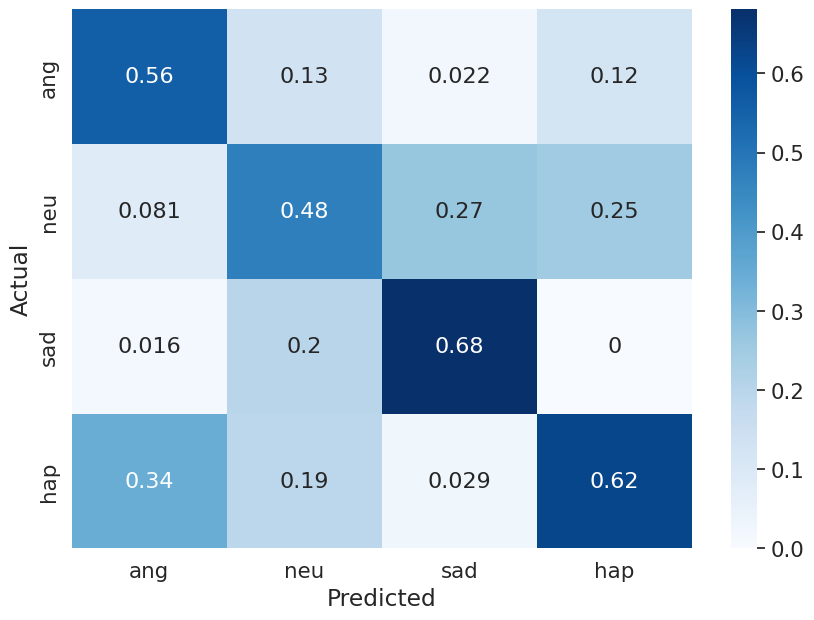

In [20]:
labels = dataset_config.target_labels
cm = cm.cpu()
a = cm / reduce(cm, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

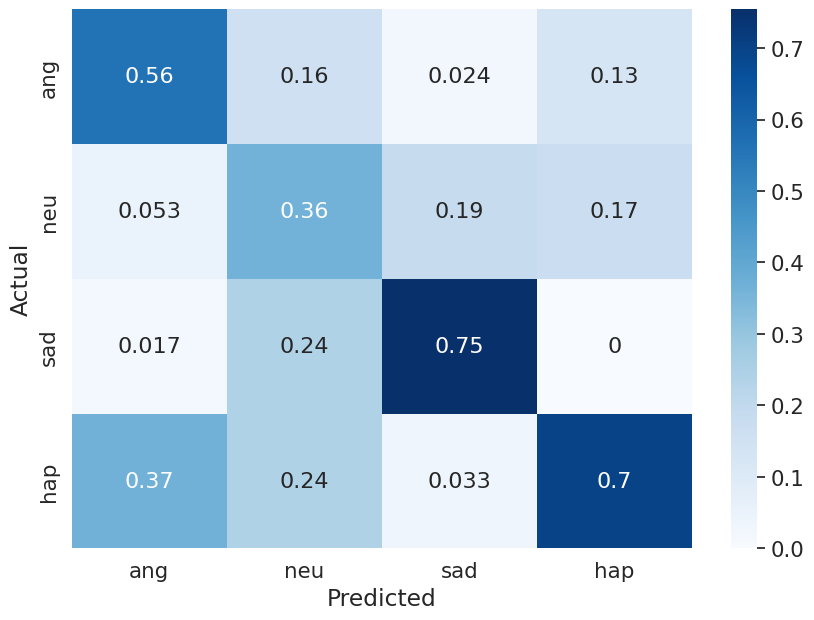

In [21]:
a = cm / reduce(cm, 'y yh -> y 1', 'sum')
a /= reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [13]:
trainer.load_best_model(val_model=True)

Loaded: ../scb14_models/iemocap/model.epoch=21.step=35404.loss=0.199.val_acc=0.645.pt


In [15]:
from pprint import pprint

In [15]:
metrics, metrics_details, confusion_matrix = trainer.test_step()
me = metrics.compute()
med = metrics_details.compute()
cm = confusion_matrix.compute()

Correct: 571/988 (0.5779)
Saved new best test model: ../scb14_models/iemocap/model.epoch=100.step=172700.test_acc=0.5779.pt


In [16]:
pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.5585, device='cuda:0'),
 'acc_weighted': tensor(0.5779, device='cuda:0'),
 'f1s_unweighted': tensor(0.5670, device='cuda:0'),
 'f1s_weighted': tensor(0.5750, device='cuda:0'),
 'rocauc': tensor(0.8119, device='cuda:0'),
 'uar': tensor(0.5585, device='cuda:0'),
 'wap': tensor(0.5825, device='cuda:0')}
{'acc_detail': tensor([0.5385, 0.7018, 0.5899, 0.4038], device='cuda:0'),
 'f1s_detail': tensor([0.5920, 0.6194, 0.6259, 0.4308], device='cuda:0'),
 'precision_detail': tensor([0.6575, 0.5543, 0.6667, 0.4615], device='cuda:0'),
 'recall_detail': tensor([0.5385, 0.7018, 0.5899, 0.4038], device='cuda:0'),
 'rocauc_detail': tensor([0.8577, 0.7592, 0.8834, 0.7472], device='cuda:0')}
tensor([[119,  40,   6,  56],
        [ 17, 240,  51,  34],
        [  3,  78, 128,   8],
        [ 42,  75,   7,  84]], device='cuda:0')


In [18]:
import pandas as pd
import IPython.display as ipd
import seaborn as sns

from IConNet.acov.visualize import (
    visualize_speech_codebook, get_embedding_color, 
    visualize_embedding_umap, visualize_training_curves,
    get_embedding_color_v2, get_zcs_color_v2
)

In [19]:
from einops import reduce, repeat, rearrange

<Axes: xlabel='Predicted', ylabel='Actual'>

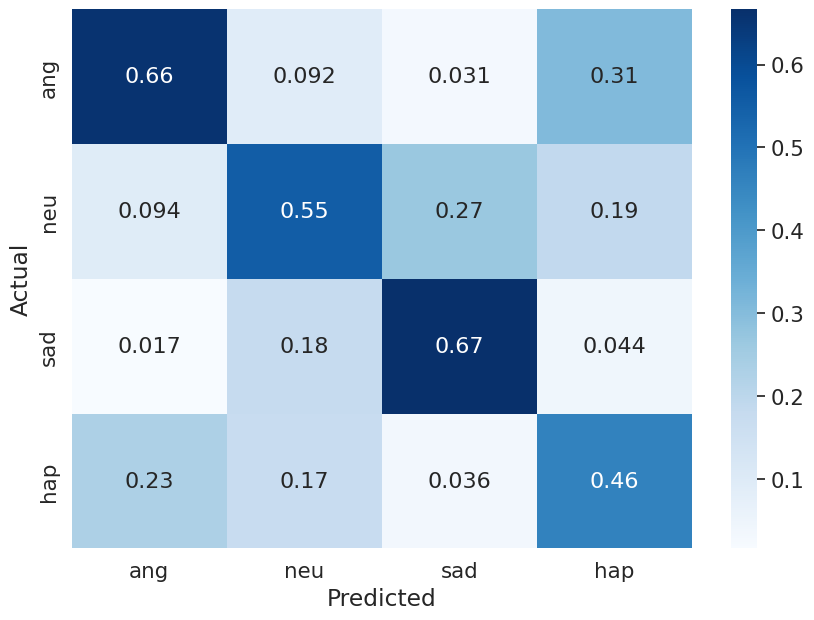

In [22]:
labels = dataset_config.target_labels
cm = cm.cpu()
a = cm / reduce(cm, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

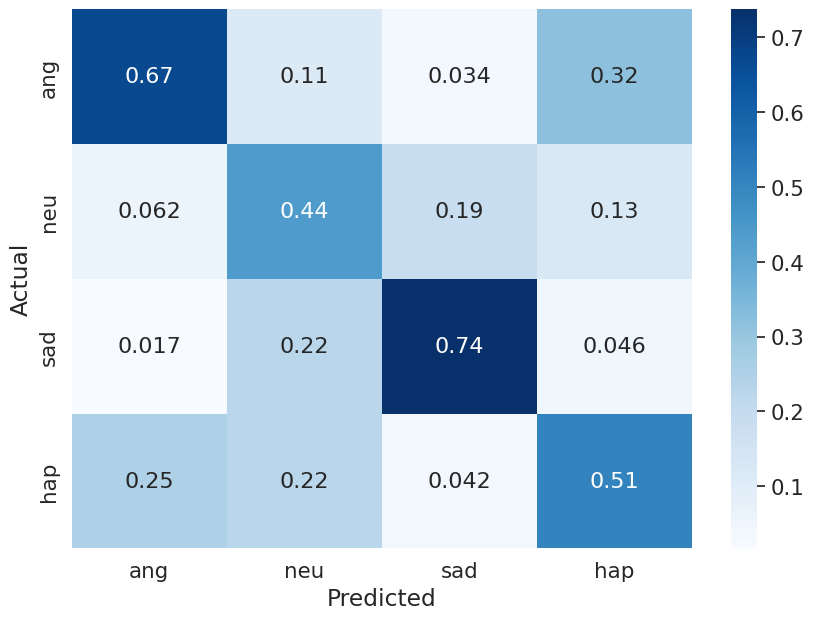

In [23]:
a = cm / reduce(cm, 'y yh -> y 1', 'sum')
a /= reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [ ]:
dt = []
for i, ld in enumerate(trainer.train_losses_detail):
    d = {'loss': trainer.train_losses[i]}
    for j, k in enumerate(ld._fields):
        d[k] = ld[j]
    dt.append(d)
loss_df = pd.DataFrame(dt)
loss_df

In [ ]:
from scipy.signal import savgol_filter

fig, axes = plt.subplots(1, 5, figsize=(14,3))
for i, c in enumerate(loss_df.columns):
    axes[i].plot(savgol_filter(loss_df[c], 301, 7))
    axes[i].set_title(c)

In [24]:
trained_epoch = trainer.current_epoch
n = len(trainer.train_losses)
trained_steps = n - (n % trained_epoch)
train_losses = reduce(np.array(
    trainer.train_losses[:trained_steps]), '(n k) -> n', 'mean', n=trained_epoch)

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

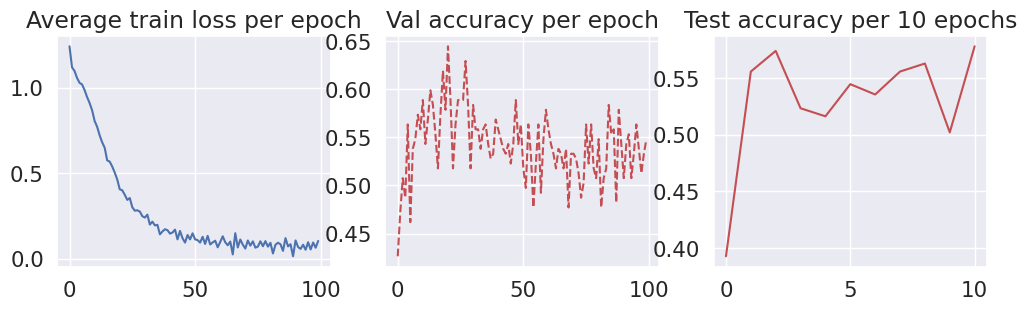

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(trainer.val_accuracy, color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [26]:
train_log = {
    'train_loss': torch.tensor(train_losses),
    'val_acc': torch.tensor(trainer.val_accuracy),
    'test_acc': torch.tensor(trainer.test_accuracy),
    'test_confusion_matrix': cm,
    'test_metrics': me,
    'test_metrics_detail': med
}
torch.save(train_log, log_dir+"train_metrics.pt")
# loss_df.to_csv(log_dir+"train_losses.csv")

In [27]:
trainer.current_step += 1

In [29]:
trainer.load(log_dir + 'model.epoch=81.step=139887.pt')

In [30]:
metrics, metrics_details, confusion_matrix = trainer.test_step()
me = metrics.compute()
med = metrics_details.compute()
cm = confusion_matrix.compute()

Correct: 556/988 (0.5628)


In [31]:
pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.5646, device='cuda:0'),
 'acc_weighted': tensor(0.5628, device='cuda:0'),
 'f1s_unweighted': tensor(0.5640, device='cuda:0'),
 'f1s_weighted': tensor(0.5642, device='cuda:0'),
 'rocauc': tensor(0.7988, device='cuda:0'),
 'uar': tensor(0.5646, device='cuda:0'),
 'wap': tensor(0.5719, device='cuda:0')}
{'acc_detail': tensor([0.5204, 0.5468, 0.6866, 0.5048], device='cuda:0'),
 'f1s_detail': tensor([0.5838, 0.5574, 0.6535, 0.4615], device='cuda:0'),
 'precision_detail': tensor([0.6647, 0.5684, 0.6234, 0.4251], device='cuda:0'),
 'recall_detail': tensor([0.5204, 0.5468, 0.6866, 0.5048], device='cuda:0'),
 'rocauc_detail': tensor([0.8100, 0.7485, 0.8828, 0.7540], device='cuda:0')}
tensor([[115,  29,  11,  66],
        [ 17, 187,  70,  68],
        [  4,  56, 149,   8],
        [ 37,  57,   9, 105]], device='cuda:0')


In [32]:
train_log = {
    'train_loss': torch.tensor(train_losses),
    'val_acc': torch.tensor(trainer.val_accuracy),
    'test_acc': torch.tensor(trainer.test_accuracy),
    'test_confusion_matrix': cm,
    'test_metrics': me,
    'test_metrics_detail': med,
    'best_model': 'model.epoch=81.step=139887.pt'
}
torch.save(train_log, log_dir+"train_metrics_bestUA.pt")

<Axes: xlabel='Predicted', ylabel='Actual'>

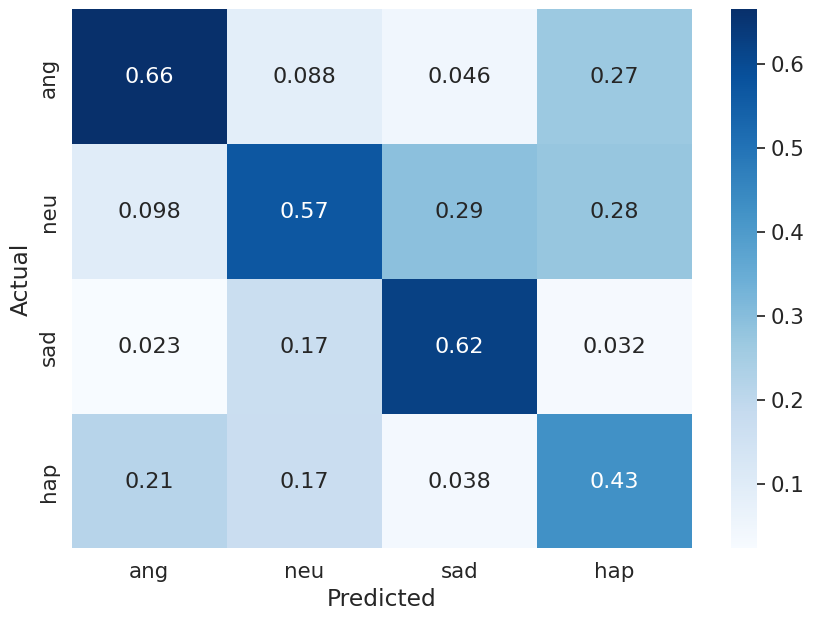

In [33]:
labels = dataset_config.target_labels
cm = cm.cpu()
a = cm / reduce(cm, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

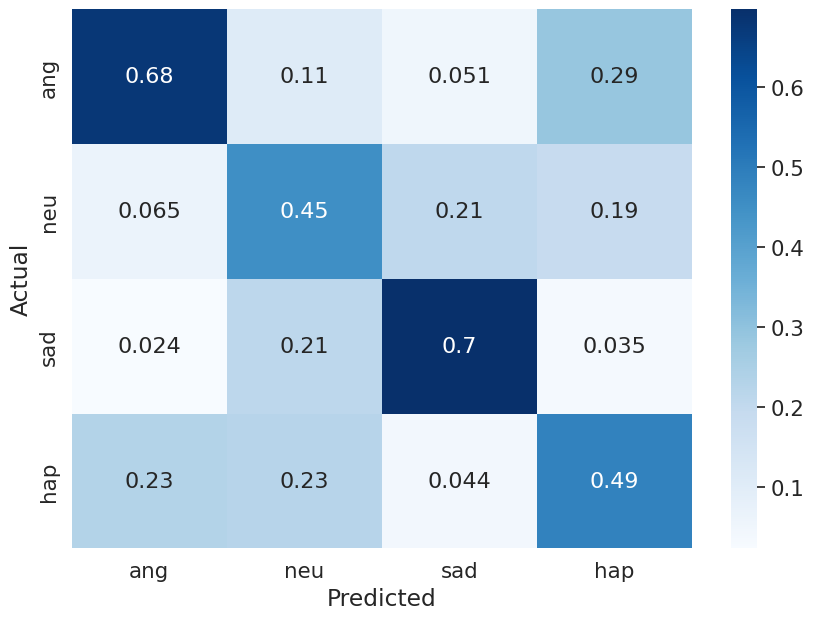

In [34]:
a = cm / reduce(cm, 'y yh -> y 1', 'sum')
a /= reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size